<a href="https://colab.research.google.com/github/dvt991/DeepLearningPyTorch/blob/master/Train_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train Classification project


## Loading Dataset with Pytorch

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# define the paths to the dataset
ds_train_path = './drive/My Drive/Datasets/imagenet_images/train/'
ds_test_path = './drive/My Drive/Datasets/imagenet_images/test/'

In [ ]:
#load the datasets into memory using ImageFolder dataset
#training dataset
dataset = ImageFolder(ds_train_path, transform=ToTensor())
#testing dataset
test_dataset = ImageFolder(ds_test_path, transform=ToTensor())

len(dataset), len(test_dataset)

(3288, 366)

In [ ]:
dataset.class_to_idx

{'track': 0, 'train': 1}

In [ ]:
#show image samples 
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  track (0)


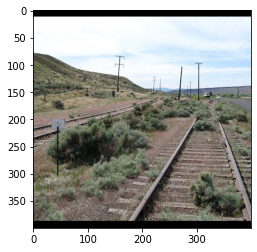

In [ ]:
show_example(*dataset[1000])

Label:  train (1)


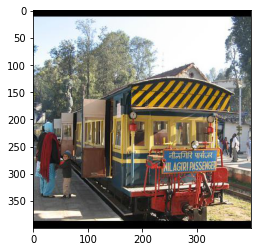

In [ ]:
show_example(*dataset[2455])

## Training and validation data preparation

In [ ]:
#need to split randomly the data into batches and separate a group for validation purposes
# we set the seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
#get validation size of 10% of the training dataset
val_size = round(len(dataset) * 0.1)
train_size = len(dataset) - val_size

#split randomly the dataset into train_ds and val_ds
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(2959, 329)

In [ ]:
#batch size
batch_size=64

In [ ]:
# we load the data in batches using the DataLoader functionality
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

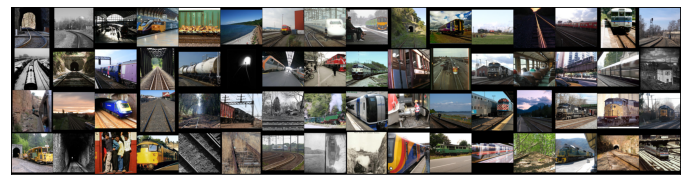

In [ ]:
#method for showing the first batch of data using the make_grip functionality
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)

## Set up for using GPU

In [ ]:
# defined first helper functions for checking and sending data to GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

#class which sends the batches of data in the dataloader to the available device
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
#check that we are in GPU mode
device = get_default_device()
device

device(type='cuda')

Now we can wrap our dataloaders using the classs defined in order to send the batches to the available device when iterating over it.

In [ ]:
train_dl_device = DeviceDataLoader(train_dl, device)
val_dl_device = DeviceDataLoader(val_dl, device)

## CNN Model creation

We create first a helper function for calculate the accuracy of our model.
Next, we crate an ImageClassificationBAse extending from nn.Module which will server as a base for our CNN model class. It contains helper functions for the training and validation process.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
#define the convolution block to be used.
#we use batch normalization
def conv_block(in_channels, out_channels, pool=True):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)  

In [ ]:
class TrainClassificationModel(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv1 = conv_block(in_channels,16) #size 16x200x200
    self.conv2 = conv_block(16,32) #size 32x100x100
    self.conv3 = conv_block(32,64) #size 64x50x50
    self.conv4 = conv_block(64,128) #size 128x25x25
    self.conv5 = conv_block(128,256) #size 256x12x12
    self.conv6 = conv_block(256, 512) #size 512x6x6
    self.conv7 = conv_block(512, 1024, False) #size 1024x6x6

    self.classifier = nn.Sequential(nn.MaxPool2d(2), # size 1024 x 3 x 3
                                    nn.Flatten(), 
                                    nn.Linear(1024*3*3, num_classes))
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.conv5(out)
    out = self.conv6(out)
    out = self.conv7(out)
    out = self.classifier(out)
    return out

In [ ]:
model = to_device(TrainClassificationModel(3,2), device)
model

TrainClassificationModel(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3)

## Training the model

Check the model output for the first batch of our training data

In [ ]:
torch.cuda.empty_cache()
for images, labels in train_dl_device:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 400, 400])
out.shape: torch.Size([64, 2])
out[0]: tensor([0.4601, 0.0989], device='cuda:0', grad_fn=<SelectBackward>)


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(TrainClassificationModel(3,2), device)
history = [evaluate(model, val_dl_device)]
history

[{'val_acc': 0.49186643958091736, 'val_loss': 0.6933054327964783}]

Lets define the hyperparameters for the training.

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
%%time
history = fit(num_epochs, lr, model, train_dl_device, val_dl_device, opt_func)

Epoch [0], train_loss: 1.2228, val_loss: 0.5292, val_acc: 0.7602
Epoch [1], train_loss: 0.5044, val_loss: 0.4131, val_acc: 0.8547
Epoch [2], train_loss: 0.4698, val_loss: 0.4581, val_acc: 0.8202
Epoch [3], train_loss: 0.4144, val_loss: 0.5807, val_acc: 0.7830
Epoch [4], train_loss: 0.4621, val_loss: 0.4211, val_acc: 0.8619
Epoch [5], train_loss: 0.4983, val_loss: 0.9637, val_acc: 0.6703
Epoch [6], train_loss: 0.4931, val_loss: 0.5173, val_acc: 0.8182
Epoch [7], train_loss: 0.3324, val_loss: 0.3826, val_acc: 0.8873
Epoch [8], train_loss: 0.3499, val_loss: 0.9608, val_acc: 0.6840
Epoch [9], train_loss: 0.2981, val_loss: 0.5471, val_acc: 0.8130
CPU times: user 1min 20s, sys: 1min, total: 2min 20s
Wall time: 4min 57s


In [ ]:
num_epochs = 3
lr = 0.0001

In [ ]:
%%time
history += fit(num_epochs, lr, model, train_dl_device, val_dl_device, opt_func)

Epoch [0], train_loss: 0.2409, val_loss: 0.3509, val_acc: 0.8723
Epoch [1], train_loss: 0.2176, val_loss: 0.3644, val_acc: 0.8769
Epoch [2], train_loss: 0.1994, val_loss: 0.3691, val_acc: 0.8652
CPU times: user 24.1 s, sys: 18.9 s, total: 43.1 s
Wall time: 1min 29s


In [ ]:
history.insert(0, {'val_acc': 0.49186643958091736, 'val_loss': 0.6933054327964783})

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

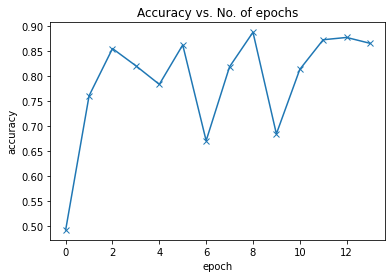

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

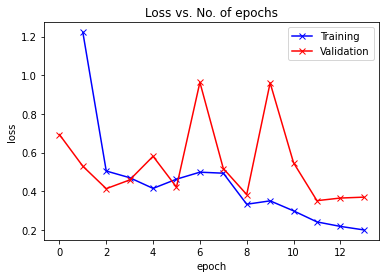

In [ ]:
plot_losses(history)

## Results with test set

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    print(" the output of he model is {}".format(yb))
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

 the output of he model is tensor([[ 1.0631, -1.4649]], device='cuda:0', grad_fn=<AddmmBackward>)
Label: track , Predicted: track


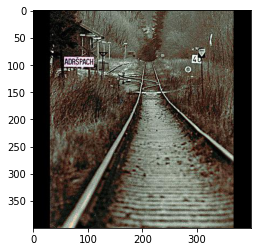

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

 the output of he model is tensor([[ 1.9252, -1.6434]], device='cuda:0', grad_fn=<AddmmBackward>)
Label: track , Predicted: track


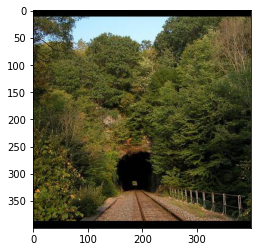

In [ ]:
img, label = test_dataset[28]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.8633996844291687, 'val_loss': 0.33969077467918396}

## Saving the model

we save now the model so it can be used for further training or prediction phases

In [ ]:
path_models = './drive/My Drive/models/'
model_name = 'trainClassifier_v1.0'
torch.save(model.state_dict(), path_models + model_name + '.pth')